# Gradient boosting

There are many different libraries which implement gradient boosting API in Python - `scikit-learn`, `xgboost`, `lightgbm` (the last two have R API as well). None of these libraries exactly replicate the estimation procedure of the `gbm` library in R. Under specific hyperparameter conditions, the `xgboost` library provides the closest alternative to `gbm`. 

This lab will primarily demonstrate the`xgboost` library under these specific settings in this lab. The library has many variations from these settings, that can potentially improve generalization performance on larger datasets. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

**Scikit-learn compatiable API**: `xgboost` provides scikit-learn compatiable APIs, that mimic regular scikit-learn estimators. `XGBRegressor` is for regression problems, and `XGBClassifier` is for classification problems. 

For the scikit-learn API, the specific settings we use are
- `tree_method` = `'approx'`
- `grow_policy`= `'lossguide'`
- `max_depth` = 0 (no limit on depth) 
- no cost complexity or regularization penalties being used.

In [3]:
from xgboost import XGBRegressor,XGBClassifier

gbm_settings = {'tree_method':'approx','grow_policy':'lossguide','max_depth':0}

## Regression

We will first demonstrate gradient boosting regression on the Concrete dataset. 

In [4]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")

# extract the predictors - no need for standardization
# we will retain the pandas DataFrame structure
X = crt.drop('Strength',axis=1)

# extract response as numpy array 
y = crt['Strength'].values

### Hyperparameter optimization

**Equivalent hyperparameters:** (under these conditions)

| xgboost (sklearn API)  | R::gbm                |
|:-----------------------|:----------------------|
| n_estimators           | n.trees               |
| max_leaves         | interaction.depth + 1 |
| learning_rate          | shrinkage             |
| min_child_weight**   | n.minobsinnode        |
| subsample              | bag.fraction          |


** provided weight of each observation is 1. This will be different from `n.minobsinnode` if that's not the case (for e.g. imbalanced classification settings). 


We will use `hyperopt` to tune the hyperparameters with K-fold RMSE as the objective. 

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope

from typing import Dict

In [6]:
# STEP 1: define search space
search_space = {
    'n_estimators': scope.int(hp.qloguniform('n_estimators',np.log(10),np.log(1500),1)), # min: 10, max: 1500 
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),7*np.log(2),1)), # min: 2, max: 128
    'min_child_weight':scope.int(hp.quniform('min_child_weight',2,100,1)),
    'subsample':hp.uniform('subsample',0.1,1)
}

# STEP2: define loss function

cv = KFold(5,random_state=1,shuffle=True)
train_test_splits = list(cv.split(X))


def cv_rmse(params:Dict):
    K = cv.get_n_splits()
    rmse_folds = [None]*K
    
    for k,(train_index,test_index) in enumerate(train_test_splits):
        
        # fit a xgboost model with the given hyperparameter settings on the training splot
        # NOTE: X is pandas dataframe use the .iloc attribute for extracting the training data
        model_fold = (
            XGBRegressor(**gbm_settings) 
            .set_params(**params) # set hyperparameters
            .fit(X.iloc[train_index,:],y[train_index])
        )
        
        # obtain predictions on the holdout fold
        y_pred_fold = model_fold.predict(X.iloc[test_index,:])
        
        # compute RMSE
        rmse_folds[k] = np.sqrt(mean_squared_error(y[test_index],y_pred_fold))
        
    return {'loss':np.mean(rmse_folds),'status':STATUS_OK} 

# STEP 3: run hyperopt
np.random.seed(123)
trials = Trials() # maintains an optimization history
best = fmin(
    cv_rmse, # loss function
    search_space, # search space
    algo=tpe.suggest,
    max_evals = 30, # number of hyperparameter configurations to explore
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|███████████████████████████████████████████████████████| 30/30 [00:55<00:00,  1.85s/trial, best loss: 3.899965197213729]


{'learning_rate': 0.0920501443274767,
 'max_leaves': 16,
 'min_child_weight': 14,
 'n_estimators': 1129,
 'subsample': 0.80577910383382}

In [7]:
# gather all results
results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['RMSE_CV'] = [tmp['loss'] for tmp in trials.results]
results['R2_cv'] = 1-results['RMSE_CV']**2/y.var()

results.sort_values('R2_cv',ascending=False).head(10)

,learning_rate,max_leaves,min_child_weight,n_estimators,subsample,RMSE_CV,R2_cv
26,0.092050,16,14,1129,0.805779,3.899965,0.945448
29,0.220585,17,8,1093,0.909247,3.921325,0.944849
27,0.028275,16,14,1480,0.803384,3.928568,0.944645
23,0.067397,12,14,1484,0.977701,3.929120,0.944629
5,0.147379,125,3,834,0.642264,4.185224,0.937176
25,0.045335,6,14,524,0.993028,4.518815,0.926761
20,0.482482,22,3,1365,0.984085,4.585208,0.924594
22,0.409140,22,2,33,0.775241,4.730337,0.919745
2,0.050968,73,89,804,0.874630,4.816064,0.916809
10,0.213018,3,24,116,0.735704,5.327711,0.898194


### Comparison with other methods

In [8]:
from sklearn.model_selection import RepeatedKFold
# 5 replicates of 5-fold CV
n_folds = 5
n_repeats=5
rkf = RepeatedKFold(n_splits=n_folds,n_repeats=n_repeats)
mses_rkf = np.empty(n_folds*n_repeats)


for i,(train_index,test_index) in enumerate(rkf.split(X)):   
    # create new model by clonining the initial object with the specified hyperparameters
    model_fold = (
        XGBRegressor(**gbm_settings) 
        .set_params(**best) # set best hyperparameters from earlier
        .fit(X.iloc[train_index,:],y[train_index])
    )

    # compute test predictions
    y_test_pred = model_fold.predict(X.iloc[test_index,:])
    # compute metric-mean-squared error
    mses_rkf[i] = mean_squared_error(y[test_index],y_test_pred)
    
mse_xgb_cv = mses_rkf.mean()
r2_xgb_cv = 1-mse_xgb_cv/y.var()

print('CV R2.....: %5.3f'%r2_xgb_cv)

CV R2.....: 0.939


For reference

    CV R2 for neural network.....: 0.914 (tuned using grid search)
    CV R2 for random forest......: 0.891
    CV R2 for GAM regression.....: 0.885
    CV R2 for regression tree....: 0.797
    CV R2 for linear regression..: 0.605


### Final model

In [9]:
regr_final = (
    XGBRegressor(**gbm_settings) 
    .set_params(**best) # set best hyperparameters from earlier
    .fit(X,y)
)

Feature importances can be retrieved from the `.feature_importances_` attribute. This corresponds to the total reduction in the loss function attributable to each predictor.

In [10]:
feat_imp = regr_final.feature_importances_

# naming the entries using Pandas series
feat_imp_named = pd.Series(feat_imp,index=X.columns.to_list())

# sort in decreasing order of feature importance
feat_imp_named.sort_values(ascending=False).round(4)

Age       0.3215
Cement    0.2397
Slag      0.1273
SPlast    0.1116
Water     0.0934
FAgg      0.0430
FlyAsh    0.0394
CAgg      0.0241
dtype: float32

Like the case of the random forest, we can use `PartialDependenceDisplay` from `sklearn.inspection` to generate partial dependence plots.

In [11]:
from sklearn.inspection import PartialDependenceDisplay

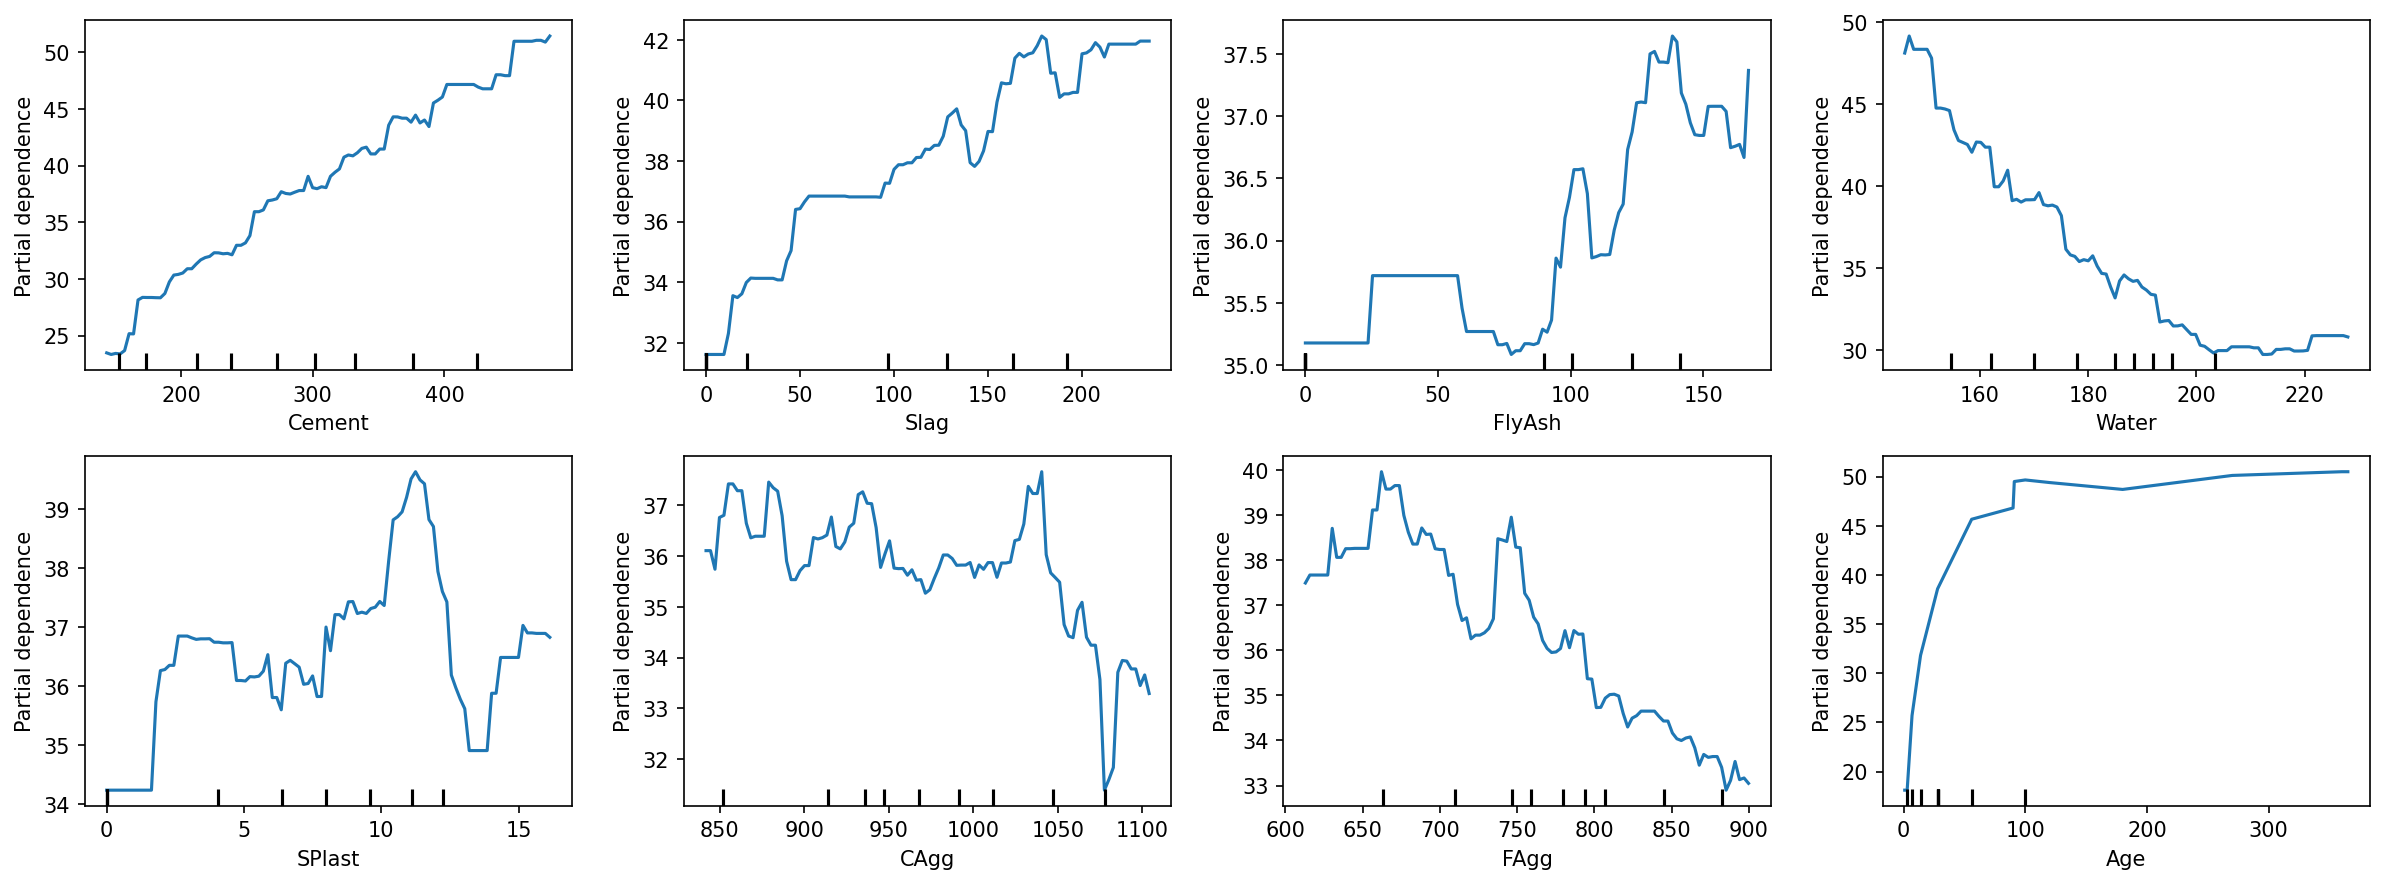

In [12]:
# 1-D Partial dependence plots
num_rows=2
num_cols=4
fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        features = [X.columns[num_cols*i+j]]
        
        _ = PartialDependenceDisplay.from_estimator(
            estimator=regr_final,
            X=X, # training data
            features=[features],
            #feature_names=X_col_names,
            ax=axs[i,j]
        )

fig.tight_layout()

## Handling categorical features - a classification example

The `xgboost` library has the options to natively handle categorical data. There are two steps needed:

1. Specify the data type of the input predictor in the pandas `DataFrame` object as `'category'`
2. Pass `enable_categorical=True` in the constructor.


To demonstrate this, we will train an xgboost model on the adult income dataset from class. I will leave tuning the hyperparameters as an exercise.

In [13]:
adult = pd.read_csv('../data/adult_train.csv')
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
# drop two  of the columns
# education and education-num convey the same information
adult = adult.drop(['education','fnlwgt'],axis=1)

# response - convert to 0/1 variable
y = 1*(adult['income']==' >50K').values

# extract predictors and response
X = adult.drop('income',axis=1) 

# extract list of categorical columns
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']
cat_cols = [col for col in X.columns if col not in numerical_cols]


# specify category datatype
for col in cat_cols:
    X[col] = X[col].astype('category')

In [15]:
# SANITY check
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       32561 non-null  category
 2   education-num   32561 non-null  int64   
 3   marital-status  32561 non-null  category
 4   occupation      32561 non-null  category
 5   relationship    32561 non-null  category
 6   race            32561 non-null  category
 7   sex             32561 non-null  category
 8   capital-gain    32561 non-null  int64   
 9   capital-loss    32561 non-null  int64   
 10  hours-per-week  32561 non-null  int64   
 11  native-country  32561 non-null  category
dtypes: category(7), int64(5)
memory usage: 1.5 MB


In [16]:
# train model

clf = (
    XGBClassifier(
        n_estimators=200,max_leaves=20,learning_rate=0.01,
        enable_categorical=True, # this needs to be True for natively handling categorical features
        **gbm_settings
    )
    .fit(X,y)
)

In [17]:
feat_imp = clf.feature_importances_

# naming the entries using Pandas series
feat_imp_named = pd.Series(feat_imp,index=X.columns.to_list())

# sort in decreasing order of feature importance
feat_imp_named.sort_values(ascending=False).round(4)

relationship      0.5924
marital-status    0.2091
capital-gain      0.0516
education-num     0.0484
occupation        0.0350
age               0.0130
capital-loss      0.0128
hours-per-week    0.0112
native-country    0.0093
workclass         0.0087
sex               0.0086
race              0.0000
dtype: float32

## XGBoost for the project

For the `xgboost` algorithm to count as a new method not covered in class, 

1. Set `grow_policy` = `'depthwise'` (the default setting). In this setting, we will only consider splits at nodes closest to the root. In the `'lossguide'` setting that we used in the lab, there is no such restriction. This will require you to tune `max_depth` as well. 

2. Tune `colsample_bytree`: This is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed. 

3. Tune the cost complexity and regularization penalties:
    - `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree
    - `reg_alpha`, `reg_lambda`: L1 and L2 regularization terms, respectively, on the number of observations or sum of weights (when sample weights are provided).